# List of Content
## 1. Import data
## 2. Customer profiling
### 2.1 Classification criteria
### 2.2 Profile flag
### 2.3 Distribution of customer profiles
### 2.4 Usage frequency and expenditure of customer profiles
## 3. Customer profiles across regions and departments
### 3.1 Regional comparison
### 3.2 Departmental comparison
## 4. Export data

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# 1. Import data

In [2]:
path = r'C:\Users\Yan Peng\10-2020 Instacart Basket Analysis'

In [4]:
df = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'orders_products_cust_active.pkl'))

In [5]:
df.shape

(30993489, 37)

In [5]:
df.columns

Index(['order_id', 'user_id', 'order_number', 'orders_day_of_week',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', '_merge', 'product_name', 'aisle_id',
       'department_id', 'prices', '_merge2', 'price_label', 'busiest_day',
       'busiest_days', 'busiest_period_of_day', 'max_order', 'loyalty_flag',
       'avg_price', 'spending_flag', 'median_days_prior', 'order_freq_flag',
       'first_name', 'surname', 'gender', 'state', 'age', 'date_joined',
       'nr_dependants', 'fam_status', 'income', '_merge3', 'region',
       'activity_flag'],
      dtype='object')

In [15]:
df_dep = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'departments_wrangled.csv'), index_col = False)

# 2. Customer profiling

## 2.1 Classification criteria

In [7]:
# Check the 'age' and 'fam_status' columns for general stats

df['age'].describe()

count    3.099349e+07
mean     4.946786e+01
std      1.848521e+01
min      1.800000e+01
25%      3.300000e+01
50%      4.900000e+01
75%      6.500000e+01
max      8.100000e+01
Name: age, dtype: float64

In [8]:
df['fam_status'].value_counts()

fam_status
married                             21763585
single                               5099384
divorced/widowed                     2647799
living with parents and siblings     1482721
Name: count, dtype: int64

In [9]:
df[df['fam_status'] == 'divorced/widowed']['age'].value_counts().sort_index()

age
60    112225
61    128753
62    118800
63    130145
64    133916
65    116311
66    107183
67    124585
68    119411
69    114322
70    117056
71    120204
72    115303
73    126709
74    115142
75    123246
76    111721
77    114227
78    122980
79    119251
80    117965
81    138344
Name: count, dtype: int64

In [10]:
df[df['fam_status'] == 'living with parents and siblings']['age'].value_counts().sort_index()

age
18    359514
19    391011
20    360430
21    371766
Name: count, dtype: int64

##### I use the following classification for customer types based on age and family status: Young single (or living with parents and siblings)/married adult (age 18-39), Middle-aged single/married adult (40-59), Older single (or divorced/widowed)/married adult (60+)

##### Notes:
##### - The stats above show that only young adults appear in the category "living with parents and siblings" and only older adults in "divorced/widowed". These customers are thus integrated into their respective singles' category.
##### - Previous analysis has shown that customers under 40 years old have an income below $70000, whereas the income level of customers over 40 is around 110000. In the current classfication, the first income group is thus implied in the profiles of Young and Middle-aged adult and the second in Older adult.

## 2.2 Profile flag

In [6]:
# Create a "age_fam_profile" column based on the criteria above

df.loc[(df['age'] <= 39) & (df['fam_status'] == 'single') | (df['fam_status'] == 'living with parents and siblings'), 'age_fam_profile'] = 'Young single adult'

In [7]:
df.loc[(df['age'] <= 39) & (df['fam_status'] == 'married'), 'age_fam_profile'] = 'Young married adult'

In [8]:
df.loc[(df['age'] >= 40) & (df['age'] <= 59) & (df['fam_status'] == 'single'), 'age_fam_profile'] = 'Middle-aged single adult'

In [9]:
df.loc[(df['age'] >= 40) & (df['age'] <= 59) & (df['fam_status'] == 'married'), 'age_fam_profile'] = 'Middle-aged married adult'

In [10]:
df.loc[(df['age'] >= 60) & (df['fam_status'] == 'single') | (df['fam_status'] == 'divorced/widowed'), 'age_fam_profile'] = 'Older single adult'

In [11]:
df.loc[(df['age'] >= 60) & (df['fam_status'] == 'married'), 'age_fam_profile'] = 'Older married adult'

In [12]:
# Frequency check on the new column

df['age_fam_profile'].value_counts().sort_index()

age_fam_profile
Middle-aged married adult    7297994
Middle-aged single adult     2436349
Older married adult          7936376
Older single adult           2647799
Young married adult          6529215
Young single adult           4145756
Name: count, dtype: int64

In [18]:
# Check non-NaN values

df['age_fam_profile'].count()

30993489

## 2.3 Distribution of customer profiles

In [23]:
# Define the desired order of the age-family profiles

desired_order = ['Young single adult', 'Young married adult', 'Middle-aged single adult', 
                 'Middle-aged married adult', 'Older single adult', 'Older married adult']

In [20]:
# Frequency check on the age-family profiles

df['age_fam_profile'].value_counts()[desired_order]

age_fam_profile
Young single adult           4145756
Young married adult          6529215
Middle-aged single adult     2436349
Middle-aged married adult    7297994
Older single adult           2647799
Older married adult          7936376
Name: count, dtype: int64

Text(0.5, 0, 'Count')

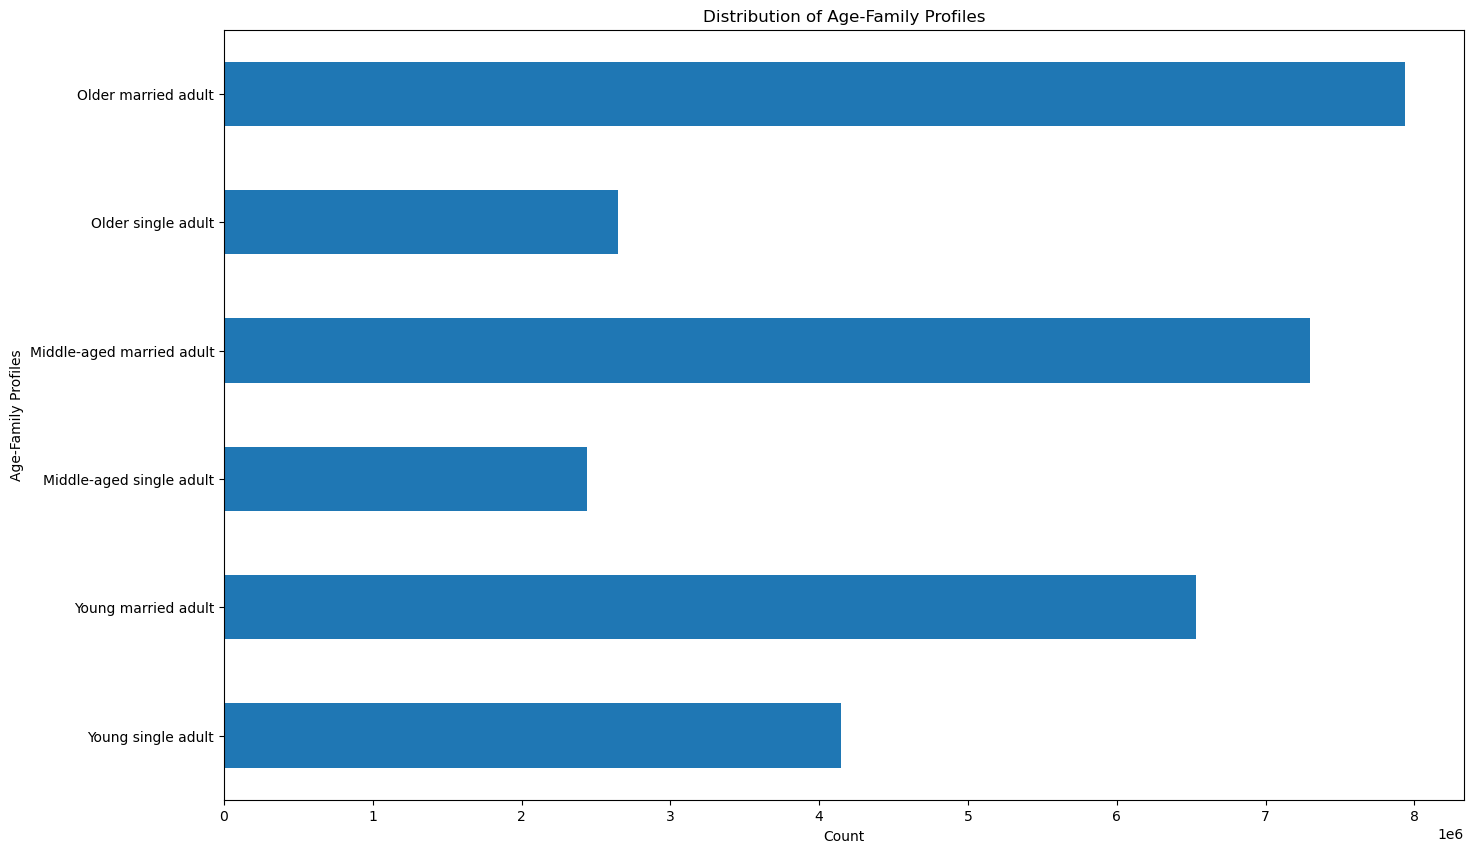

In [21]:
# Create a horizontal bar chart

bar_profile_distr = df['age_fam_profile'].value_counts()[desired_order].plot.barh(figsize=(16, 10))
plt.title('Distribution of Age-Family Profiles')
plt.ylabel('Age-Family Profiles')
plt.xlabel('Count')

##### The chart shows that married people purchase more items than single people.

In [22]:
# Export chart

bar_profile_distr.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'profile_distribution.png'))

## 2.4 Usage frequency and expenditure of customer profiles

In [23]:
# Mean, min, and max of the total order numbers and item prices

df.groupby('age_fam_profile').agg({'max_order': ['mean', 'min', 'max'], 'prices': ['min', 'mean', 'max']}).loc[desired_order]

max_order         prices                
                                mean min max    min      mean   max
age_fam_profile                                                    
Young single adult         34.506897   5  99    1.0  7.786744  25.0
Young married adult        34.503532   5  99    1.0  7.783595  25.0
Middle-aged single adult   35.038547   5  99    1.0  7.788593  25.0
Middle-aged married adult  34.208532   5  99    1.0  7.792658  25.0
Older single adult         34.710110   5  99    1.0  7.801016  25.0
Older married adult        34.236213   5  99    1.0  7.793589  25.0

##### The customer profiles exhibit similar values in terms of total number of orders and average item price purchased.

In [24]:
# Total expenditure by the customer profiles

df.groupby('age_fam_profile').agg({'prices': 'sum'}).loc[desired_order]

,prices
age_fam_profile,
Young single adult,32246314.6
Young married adult,50766622.1
Middle-aged single adult,18953345.7
Middle-aged married adult,56807815.4
Older single adult,20632376.6
Older married adult,61787811.4


##### Married people spend more money in total than single people.

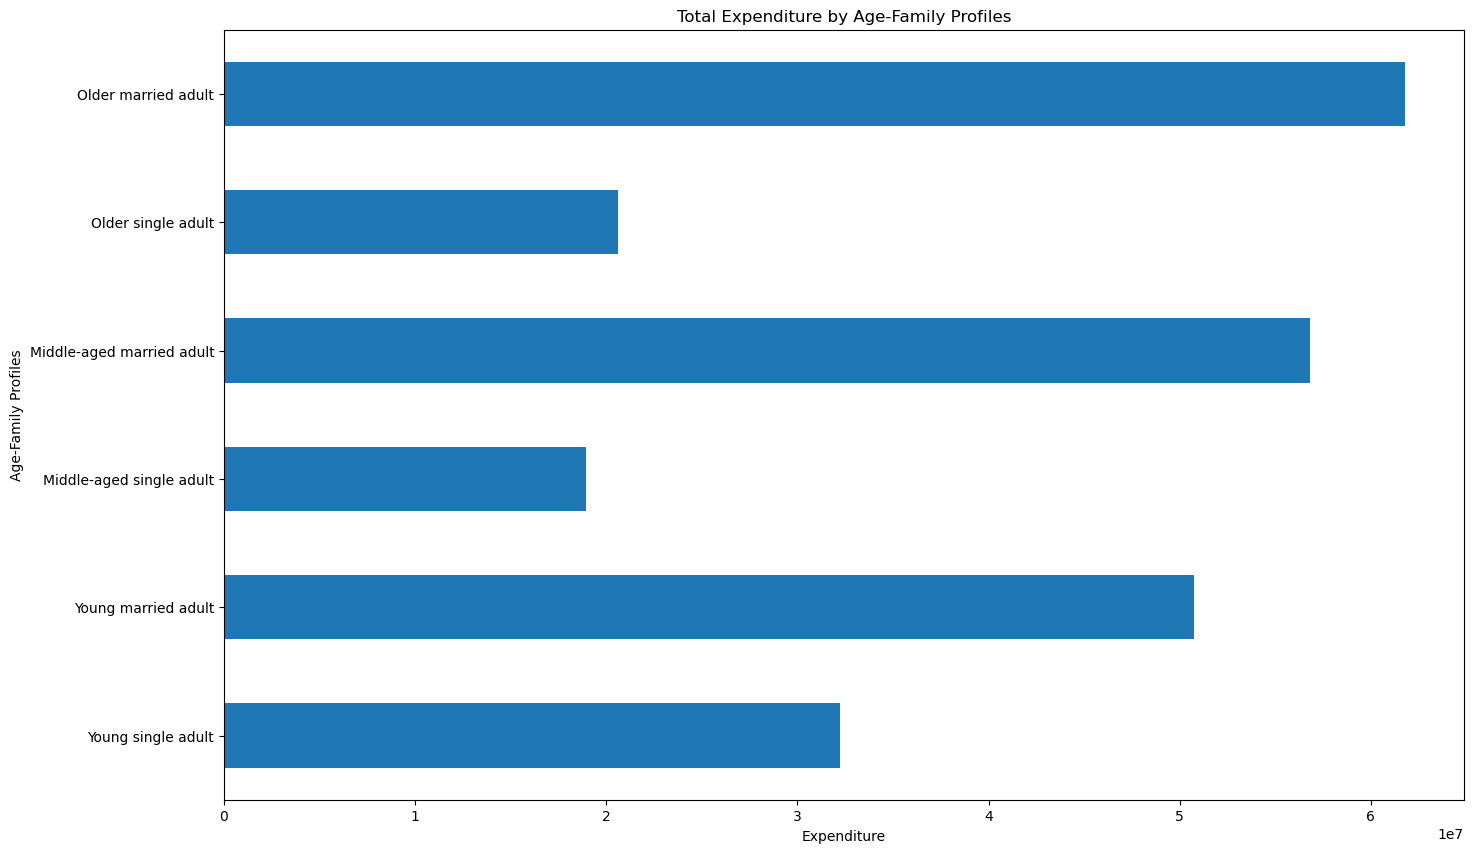

In [25]:
# Create a horizontal bar chart

bar_expend_profile = df.groupby('age_fam_profile').agg({'prices': 'sum'}).loc[desired_order].plot.barh(figsize=(16, 10))
plt.title('Total Expenditure by Age-Family Profiles')
plt.ylabel('Age-Family Profiles')
plt.xlabel('Expenditure')
plt.legend().remove()

In [26]:
# Export chart

bar_expend_profile.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'expenditure_profile.png'))

# 3. Customer profiles across regions and departments

## 3.1 Regional comparison

In [27]:
# Crosstab customer profile with region

crosstab_profile_region = pd.crosstab(df['age_fam_profile'], df['region'], dropna = False).loc[desired_order]

In [28]:
crosstab_profile_region

region,Midwest,Northwest,South,West
age_fam_profile,,,,
Young single adult,968109,727357,1412481,1037809
Young married adult,1517244,1146245,2199116,1666610
Middle-aged single adult,590403,406029,799892,640025
Middle-aged married adult,1734752,1304473,2384658,1874111
Older single adult,617718,479247,878059,672775
Older married adult,1839676,1406813,2646625,2043262


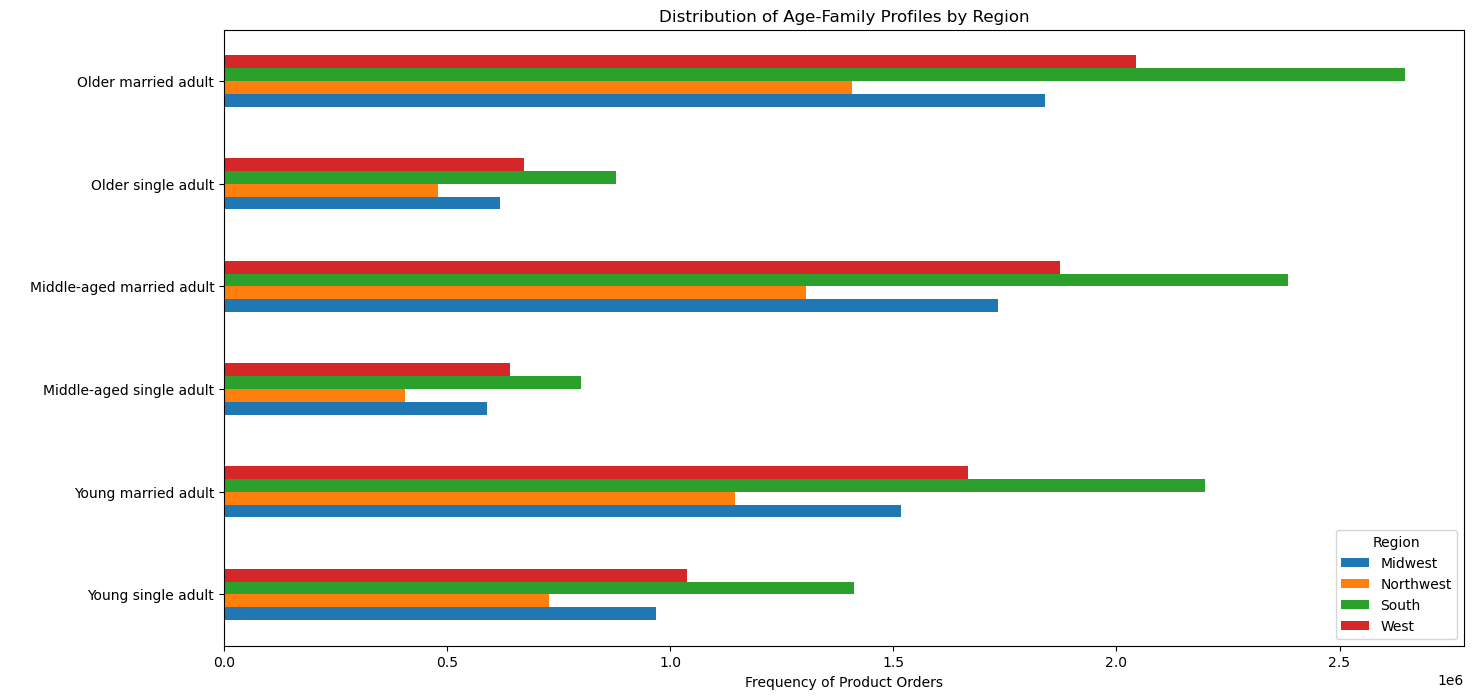

In [50]:
# Create a stacked bar chart

bar_profile_region = crosstab_profile_region.plot.barh(figsize=(16, 8))

plt.title('Distribution of Age-Family Profiles by Region')
plt.ylabel(' ')
plt.xlabel('Frequency of Product Orders')
plt.legend(title='Region', loc='lower right')

##### Married people purchase more items than single people across all four regions.

In [51]:
# Export chart

bar_profile_region.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'profile_region.png'))

## 3.2 Departmental comparison

In [16]:
# Check the dataframe with the department names

df_dep.head()

,Unnamed: 0,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [17]:
# Rename the first column as "department_id"

df_dep.rename(columns={'Unnamed: 0':'department_id'}, inplace=True)

In [18]:
# Merge the large dataframe with df_dep

df_2 = df.merge(df_dep, on = 'department_id', indicator = '_merge4')

In [19]:
df_2.head()

,order_id,user_id,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,_merge,...,date_joined,nr_dependants,fam_status,income,_merge3,region,activity_flag,age_fam_profile,department,_merge4
0,2539329,1,1,2,8,NaN,196,1,0,both,...,2/17/2019,3,married,40423,both,South,Active customers,Young married adult,beverages,both
1,2398795,1,2,3,7,15.0,196,1,1,both,...,2/17/2019,3,married,40423,both,South,Active customers,Young married adult,beverages,both
2,473747,1,3,3,12,21.0,196,1,1,both,...,2/17/2019,3,married,40423,both,South,Active customers,Young married adult,beverages,both
3,2254736,1,4,4,7,29.0,196,1,1,both,...,2/17/2019,3,married,40423,both,South,Active customers,Young married adult,beverages,both
4,431534,1,5,4,15,28.0,196,1,1,both,...,2/17/2019,3,married,40423,both,South,Active customers,Young married adult,beverages,both


In [20]:
# Crosstab customer profil with departments

crosstab_profile_dep = pd.crosstab(df_2['department'], df_2['age_fam_profile'], dropna = False)

In [21]:
# Calculate the row sums and sort the crosstab based on row sums; sort 'age_fam_profile' in the desired order

row_sums = crosstab_profile_dep.sum(axis=1)

In [24]:
ct_sorted = crosstab_profile_dep.loc[row_sums.sort_values(ascending=True).index][desired_order]

In [25]:
ct_sorted

age_fam_profile,Young single adult,Young married adult,Middle-aged single adult,Middle-aged married adult,Older single adult,Older married adult
department,,,,,,
bulk,4423,7201,2534,7869,2676,8748
other,4942,7176,2745,7944,2842,8762
missing,9085,13414,5103,15379,5064,16723
pets,13461,18457,7454,21933,8025,23730
alcohol,20994,30662,12353,33022,11859,35737
international,34961,53885,20080,60617,21814,64634
babies,55705,85751,32653,97545,34351,104387
personal care,56941,87866,33152,102619,36313,107415
breakfast,90047,141892,52993,158167,56590,171161


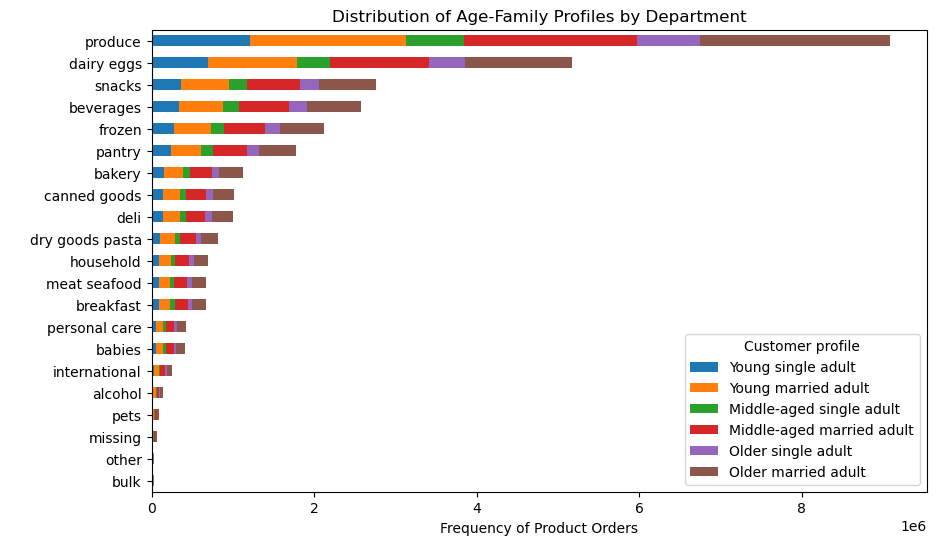

In [26]:
# Create a stacked bar chart

bar_profile_dep = ct_sorted.plot.barh(stacked=True, figsize=(10, 6))

plt.title('Distribution of Age-Family Profiles by Department')
plt.ylabel(' ')
plt.xlabel('Frequency of Product Orders')
plt.legend(title='Customer profile', loc='lower right')

##### Married people purchase more than single people across all departments.

In [27]:
# Export chart

bar_profile_dep.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'profile_department.png'))

# 4. Export data

In [41]:
df_2.head()

,order_id,user_id,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,_merge,...,date_joined,nr_dependants,fam_status,income,_merge3,region,activity_flag,age_fam_profile,department,_merge4
0,2539329,1,1,2,8,NaN,196,1,0,both,...,2/17/2019,3,married,40423,both,South,Active customers,Young married adult,beverages,both
1,2398795,1,2,3,7,15.0,196,1,1,both,...,2/17/2019,3,married,40423,both,South,Active customers,Young married adult,beverages,both
2,473747,1,3,3,12,21.0,196,1,1,both,...,2/17/2019,3,married,40423,both,South,Active customers,Young married adult,beverages,both
3,2254736,1,4,4,7,29.0,196,1,1,both,...,2/17/2019,3,married,40423,both,South,Active customers,Young married adult,beverages,both
4,431534,1,5,4,15,28.0,196,1,1,both,...,2/17/2019,3,married,40423,both,South,Active customers,Young married adult,beverages,both


In [42]:
df_2.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'orders_products_cust_active_dep.pkl'))